In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
import keras
import tensorflow.compat.v1 as tf
import numpy as np

Using TensorFlow backend.


In [2]:
trainImagesFile = 'train_images.csv'
trainLabelsFile = 'train_labels.csv'
testImagesFile = 'test_images.csv'
testLabelsFile = 'test_labels.csv'

In [3]:
dfTrainImages = pd.read_csv('data/' + trainImagesFile, index_col=False, header=None)
dfTrainLabels = pd.read_csv('data/' + trainLabelsFile)
dfTestImages = pd.read_csv('data/' + testImagesFile, index_col=False, header=None)
dfTestLabels = pd.read_csv('data/' + testLabelsFile)

In [4]:
print(dfTrainImages.shape)
print(dfTrainLabels.shape)

(7000, 12100)
(7000, 4)


In [5]:
dfTrainLabels.head()

,Volcano?,Type,Radius,Number Volcanoes
0,1,3.0,17.46,1.0
1,0,NaN,NaN,NaN
2,0,NaN,NaN,NaN
3,0,NaN,NaN,NaN
4,0,NaN,NaN,NaN


In [6]:
dfTrainImages = dfTrainImages.values
dfTrainLabels = dfTrainLabels.values
dfTestImages = dfTestImages.values
dfTestLabels = dfTestLabels.values

In [7]:
dfTrainLabels = np.nan_to_num(dfTrainLabels)
dfTestLabels = np.nan_to_num(dfTestLabels)

In [8]:
dfTrainLabels[:2,:]

array([[ 1.  ,  3.  , 17.46,  1.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ]])

In [9]:
trainLabels = dfTrainLabels[:,1]
testLabels = dfTestLabels[:,1]

zeros = np.where(trainLabels == 0)[0]
ones = np.where(trainLabels == 1)[0]
twos = np.where(trainLabels == 2)[0]
threes = np.where(trainLabels == 3)[0]
fours = np.where(trainLabels == 4)[0]

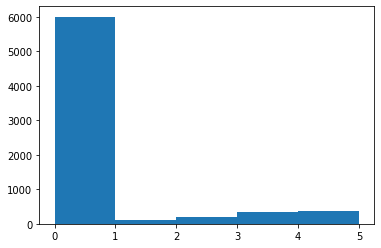

In [10]:
plt.hist(trainLabels, bins=[0,1,2,3,4,5])
plt.show()

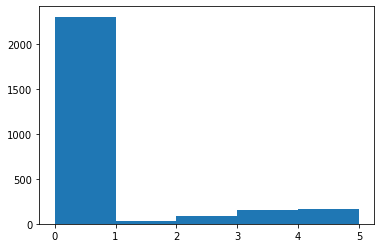

In [11]:
plt.hist(testLabels, bins=[0,1,2,3,4,5])
plt.show()

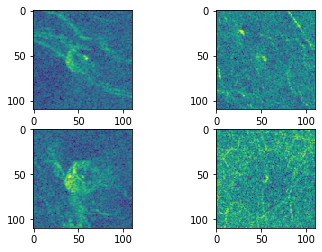

In [12]:
for i in range(0,4):
    img = np.random.choice(len(ones))
    plt.subplot(221 + (i))
    plt.imshow(dfTrainImages[ones[img]].reshape(110,110))
plt.show()

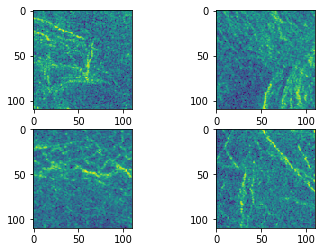

In [13]:
for i in range(0,4):
    img = np.random.choice(len(zeros))
    plt.subplot(221 + (i))
    plt.imshow(dfTrainImages[zeros[img]].reshape(110,110))
plt.show()

In [14]:
def augmentImages(images, multFactor):
    gen = ImageDataGenerator()
    newImages = []
    for _ in range(multFactor):
        for image in images:
            transformedImage = gen.apply_transform(image, {'theta': np.random.choice(range(270)), 'brightness': np.random.uniform(low=0.01,high=0.99)})
            newImages.append(transformedImage)
    newImages = np.array(newImages)
    return newImages

In [15]:
trainLabels = keras.utils.to_categorical(trainLabels, 5)
testLabels = keras.utils.to_categorical(testLabels, 5)

In [16]:
dfTrainImages = dfTrainImages.reshape(-1, 110, 110, 1)
dfTestImages = dfTestImages.reshape(-1, 110, 110, 1)

In [17]:
model = Sequential()
model.add(Conv2D(16, (4,4), activation='relu', input_shape=(110,110,1)))
model.add(Conv2D(32, (2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (2,2), activation='relu'))
model.add(Conv2D(128, (2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [18]:
model.compile(optimizer=keras.optimizers.SGD(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
noVolcanoes = dfTrainImages[zeros]
volcanoes = dfTrainImages[ones]
volcanoes2 = dfTrainImages[twos]
volcanoes3 = dfTrainImages[threes]
volcanoes4 = dfTrainImages[fours]

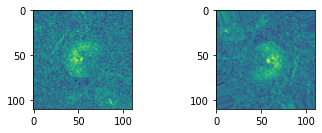

In [20]:
newImage = augmentImages([volcanoes[0]], multFactor=1)
plt.subplot(221)
plt.imshow(volcanoes[0].reshape(110,110))
plt.subplot(222)
plt.imshow(newImage.reshape(110,110))
plt.show()

In [21]:
augmentedVolcanoes  = augmentImages(volcanoes,  multFactor=50) 
augmentedVolcanoes2 = augmentImages(volcanoes2, multFactor=35)
augmentedVolcanoes3 = augmentImages(volcanoes3, multFactor=15)
augmentedVolcanoes4 = augmentImages(volcanoes4, multFactor=15)

In [22]:
x_train = np.vstack([noVolcanoes, augmentedVolcanoes, augmentedVolcanoes2, augmentedVolcanoes3, augmentedVolcanoes4])

In [23]:
noVolcanoesLabels = np.zeros(noVolcanoes.shape[0])
augmentedVolcanoesLabels = np.ones(augmentedVolcanoes.shape[0])
augmentedVolcanoes2Labels = 2*np.ones(augmentedVolcanoes2.shape[0])
augmentedVolcanoes3Labels = 3*np.ones(augmentedVolcanoes3.shape[0])
augmentedVolcanoes4Labels = 4*np.ones(augmentedVolcanoes4.shape[0])

In [24]:
y_train = np.hstack([noVolcanoesLabels, augmentedVolcanoesLabels, augmentedVolcanoes2Labels, augmentedVolcanoes3Labels, augmentedVolcanoes4Labels])

In [25]:
x_train, y_train = shuffle(x_train, y_train)
y_train = keras.utils.to_categorical(y_train, 5)

In [29]:
model.fit(x_train, y_train, batch_size=1, verbose=1, epochs=50)

Epoch 1/50


ResourceExhaustedError:  OOM when allocating tensor with shape[80000,512] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node mul_16 (defined at D:\apps\Anaconda3\envs\tf1x\lib\site-packages\tensorflow_core\python\framework\ops.py:1751) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_keras_scratch_graph_1006]

Function call stack:
keras_scratch_graph


In [ ]:
score = model.evaluate(dfTstImages, testLabels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])